##### Some inline magic for making matplotlib work with JupyterLab v3

In [1]:
%matplotlib widget

#### Adding ODESA folder to the path for easy import  

In [2]:
import sys, os
sys.path.append(os.path.join(sys.path[0], '..','..'))

Import the utility classes for ODESA

In [3]:
# import numpy as np
# from OdesaHidden import OdesaHidden as HiddenLayer
# from OdesaClassifier import OdesaClassifier as OutputLayer
# import os
# import math
# from tqdm import trange
# from MorseLine import MorseLine
# from MorseLineTest import MorseLineTest

# np.random.seed(1)

import numpy as np
from ODESA.FullyConnected import FullyConnected as HiddenLayer
from ODESA.Classifier import Classifier as OutputLayer

# from OdesaHidden import OdesaHidden as HiddenLayer
# from OdesaClassifier import OdesaClassifier as OutputLayer
import os
import math
from tqdm import trange
from MorseLine import MorseLine
from MorseLineTest import MorseLineTest

np.random.seed(1)



In [4]:
dim = 2

lines = ["shall i compare thee to a summers day thou art more lovely and more temperate rough winds do shake the darling buds of may and summers lease hath all too short a date sometime too hot the eye of heaven shines"]


In [5]:

env = MorseLine(dim,1,"shall i compare thee to a summers day","thou art more lovely and more temperate","rough winds do shake the darling buds of may","and summers lease hath all too short a date")#,"sometime too hot the eye of heaven shines")
testEnv = MorseLineTest("shall i compare thee to a summers day","thou art more lovely and more temperate","rough winds do shake the darling buds of may","and summers lease hath all too short a date")#,"sometime too hot the eye of heaven shines")


# env = MorseCode(dim,5,['0','0','1','0','0'],['0','0','0','1','0'])

In [6]:
cumulative_time_surfaces = True

# tau_1 = 1. TAUS for Shakespeare
tau_1 = 21 
tau_2 = 39 
tau_3 = 626 

eta_scale = 0.1
eta_1 = 0.001*0.1*eta_scale
eta_2 = 0.01*0.1*eta_scale
eta_3 = 0.08*0.1*eta_scale

first_layer_context_rows = 1 
first_layer_context_cols = dim
first_layer_n_neurons = 8
first_layer_eta = eta_1
first_layer_threshold_open = 0.01
first_layer_tau = tau_1
first_layer_trace_tau = tau_2
first_layer_thresh_eta = eta_1
first_layer_cumulative_ts = cumulative_time_surfaces
first_layer_ratio_reward = 1


first_layer = HiddenLayer(first_layer_context_rows, 
                               first_layer_context_cols,
                               first_layer_n_neurons,
                               first_layer_eta,
                               first_layer_threshold_open,
                               first_layer_tau,
                               first_layer_trace_tau,
                               first_layer_thresh_eta,
                               first_layer_cumulative_ts)

second_layer_context_rows = 1 
second_layer_context_cols = first_layer_n_neurons
second_layer_n_neurons = 28
second_layer_eta = eta_2
second_layer_threshold_open = 0.01
second_layer_tau = tau_2
second_layer_trace_tau = 4*6*10*2
second_layer_thresh_eta = eta_2
second_layer_cumulative_ts = cumulative_time_surfaces
second_layer_ratio_reward = 1


second_layer = HiddenLayer(second_layer_context_rows, 
                               second_layer_context_cols,
                               second_layer_n_neurons,
                               second_layer_eta,
                               second_layer_threshold_open,
                               second_layer_tau,
                               second_layer_trace_tau,
                               second_layer_thresh_eta,
                               second_layer_cumulative_ts)



output_layer_context_rows = 1 
output_layer_context_cols = second_layer_n_neurons
output_layer_n_classes = 4
output_layer_n_neurons_per_class = 1
output_layer_eta = eta_3
output_layer_threshold_open = 0.005
output_layer_tau = tau_3
output_layer_cumulative_ts = cumulative_time_surfaces
output_layer_thresh_eta = eta_3




output_layer = OutputLayer(output_layer_context_rows,
                                output_layer_context_cols,
                                output_layer_n_neurons_per_class,
                                output_layer_n_classes,
                                output_layer_eta,
                                output_layer_tau,
                                output_layer_threshold_open,
                                output_layer_thresh_eta,
                                cumulative_ts=output_layer_cumulative_ts)


In [7]:
# from OdesaModel import OdesaModel
from ODESA.FCModel import FCModel as OdesaModel


model = OdesaModel()
# Add hidden layers. Copy the statement to add more layers to the network.  
# model.add_hidden_layer(input_layer)
model.add_hidden_layer(first_layer)
model.add_hidden_layer(second_layer)
# Finally add the output layer. Every model has to have an output layer. 
model.add_output_layer(output_layer)


In [8]:
import matplotlib.pyplot as plt

def pltcolor(lst):
    cols=[]
    for l in lst:
        if l[0]==0:
#             cols.append('red')
            cols.append('#ca0020')
        elif l[0]==1:
            cols.append('#f4a582')
#             cols.append('blue')
        elif l[0]==2:
            cols.append('#1a9641')
#             cols.append('green')
        elif l[0]==3:
            cols.append('#2c7bb6')
#             cols.append('orange')
        else:
            cols.append('black')
    return cols

def run_testing(model,env):
    example = 0

    
    env.reset()
    model.reset()
    data_plot = []
    first_plot = []
    second_plot = []
    output_plot = []
    true_plot = []
    tp = 0
    tn = 0
    fp = 0
    fn = 0
#     number_of_events = 0
    while example < 4:
        (x,y,ts,label,curr_word,curr_letter) = env.next_event()
#         number_of_events += 1
        if y > -1:
            data_plot.append([y,ts])
        winners, output_winner, output_class = model.infer((x,y,ts,1))

        for layer_idx, winner in enumerate(winners):
            if layer_idx == 0:
                if winner > -1:
                    first_plot.append([winner,ts])
            elif layer_idx == 1:
                if winner > -1:
                    second_plot.append([winner,ts])

        if output_winner > -1:
            output_plot.append([output_winner,ts])
        
        if output_class == 0:
            if label == 0:
                tp += 1
            else:
                fp += 1
        else:
            if label == 0:
                fn += 1
            else:
                tn += 1
        

        if label > -1 :
            true_plot.append([label,ts])
            example = example + 1
#     print(number_of_events)
#     print("Sensitivity: {} Specificity: {}".format(tp/(tp+fn), tn/(tn+fp)))
    return data_plot, first_plot, second_plot, output_plot, true_plot


def run_training(sim_time,epochs,model,env,sensitivity_plot,specificity_plot,thresh_plot,label_list,pred_list):

    correct_class_percent = 0
    wrong_class_percent = 0
    no_class_percent = 0
    tqrange = trange(epochs, desc='accuracy ',leave=True)

    for epoch in tqrange:
        env.reset()
        model.reset()
        correct_count = 0
        wrong_count = 0
        no_count = 0
        tp = 0
        tn = 0
        fp = 0
        fn = 0

        for t in range(sim_time):
            (x,y,ts,label,curr_word,curr_letter) = env.next_event()
            winners, output_winner, output_class = model.forward((x,y,ts,1),label)
            if label > -1 :
                if output_winner > -1:
                    if output_class == label:

                        correct_count += 1
                    else:
                        wrong_count += 1
                else:
                    no_count += 1
            if label == 0:
                label_list.append(label)
            else:
                label_list.append(-1)
            if output_class == 0:
                pred_list.append(output_class)
            else:
                pred_list.append(-1)
                
            thresh_plot.append(model.output_layer.thresh[0])
            # if output_class == 0:
            #     if label == 0:
            #         tp += 1
            #     else:
            #         fp += 1
            # else:
            #     if label == 0:
            #         fn += 1
            #     else:
            #         tn += 1
#         print("Sensitivity: {} Specificity: {}".format(tp/(tp+fn+1e-6), tn/(tn+fp+1e-6)))
        # sensitivity_plot.append(tp/(tp+fn+1e-6))
        # specificity_plot.append(tn/(tn+fp+1e-6))
        # thresh_plot.append(model.output_layer.thresh[0])
        
        correct_class_percent = correct_count/(correct_count+no_count+wrong_count)
#         if correct_class_percent > 0.9:
#             break
#         no_class_percent = no_count/(correct_count+no_count+wrong_count)
#         wrong_class_percent = wrong_count/(correct_count+no_count+wrong_count)
        tqrange.set_description("accuracy : {}".format(correct_class_percent),refresh=True)

    return model

In [9]:
import time
from IPython.display import clear_output

sim_time = 342000
epochs = 1
data_plots = []
first_plots = []
second_plots = []
output_plots = []
true_plots = []
sensitivity_plot = []
specificity_plot = []
thresh_plot = []
label_list = []
pred_list = []

for trials in range(10):
    model = run_training(sim_time,epochs,model,env,sensitivity_plot,specificity_plot,thresh_plot,label_list, pred_list)
    data_plot, first_plot, second_plot, output_plot, true_plot = run_testing(model,testEnv)
    data_plots.append(data_plot)    
    first_plots.append(first_plot)    
    second_plots.append(second_plot)    
    output_plots.append(output_plot)    
    true_plots.append(true_plot)

accuracy : 0.9677741693729702: 100%|██████████| 1/1 [00:24<00:00, 24.92s/it]


In [10]:
import pickle
with open('labels_list.pkl', 'wb') as f:
    pickle.dump(label_list, f)
    
with open('pred_list.pkl', 'wb') as f:
    pickle.dump(pred_list, f)

with open('thresh_list.pkl', 'wb') as f:
    pickle.dump(thresh_plot, f)

In [12]:
labels = np.asarray(label_list)
preds = np.asarray(pred_list)
threshs = np.asarray(thresh_plot)
window_s = 2000

total_samples = np.sum(labels==0)
total_events = labels.shape[0]



346.04877061620965


In [42]:
sens_list = []
spec_list = []
thresh_list = []
window_s = 3500

for i in range(window_s,total_events,350):
    labels_win = labels[i-window_s:i]
    preds_win = preds[i-window_s:i]
    tp = np.sum(np.logical_and(labels_win==0,preds_win==0))
    tn = np.sum(np.logical_and(labels_win==-1,preds_win==-1))
    fp = np.sum(np.logical_and(labels_win==-1,preds_win==0))
    fn = np.sum(np.logical_and(labels_win==0,preds_win==-1))
    sens_list.append(tp/(tp+fn+1e-6))
    spec_list.append(tn/(tn+fp+1e-6))
    thresh_list.append(np.average(threshs[i-window_s:i]))
    

    
    

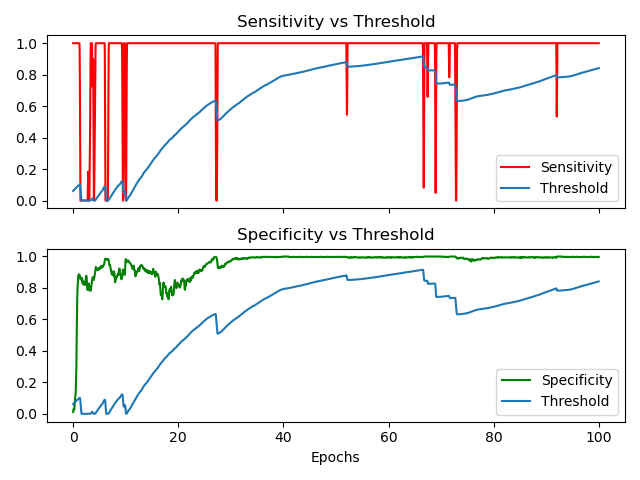

In [57]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

sensitivity_plot = moving_average(np.asarray(sens_list),10)
specificity_plot = moving_average(np.asarray(spec_list),10)
thresh_plot = moving_average(np.asarray(thresh_list),10)
x_axis_list = (100/len(sensitivity_plot))*np.arange(0,len(sensitivity_plot),1)
fig, axs = plt.subplots(2,1,sharex=True)

axs[0].plot(x_axis_list,sensitivity_plot,c='r',label='Sensitivity')
axs[0].plot(x_axis_list,thresh_plot,label='Threshold')
axs[0].set_title('Sensitivity vs Threshold')
axs[0].legend()
axs[1].plot(x_axis_list,specificity_plot,c='g',label='Specificity')
axs[1].plot(x_axis_list,thresh_plot,label='Threshold')
axs[1].set_title('Specificity vs Threshold')
axs[1].legend()
axs[1].set(xlabel="Epochs")


fig.tight_layout()
plt.show()

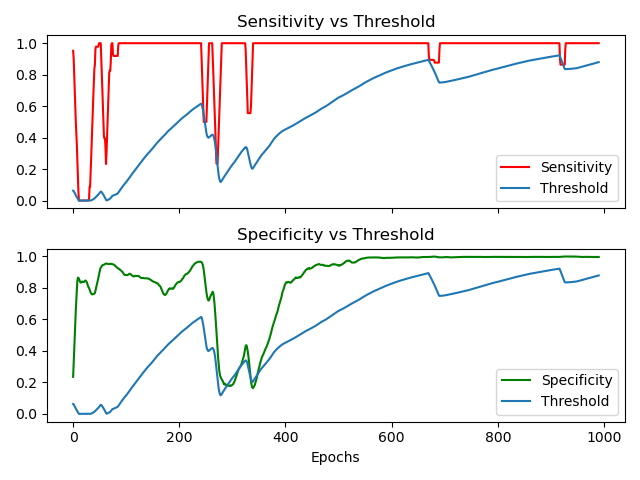

In [11]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# data = np.array([10,5,8,9,15,22,26,11,15,16,18,7])

# print(moving_average(data,4))
sensitivity_plot = moving_average(np.asarray(sensitivity_plot),10)
specificity_plot = moving_average(np.asarray(specificity_plot),10)
thresh_plot = moving_average(np.asarray(thresh_plot),10)

fig, axs = plt.subplots(2,1,sharex=True)

axs[0].plot(sensitivity_plot,c='r',label='Sensitivity')
axs[0].plot(thresh_plot,label='Threshold')
axs[0].set_title('Sensitivity vs Threshold')
axs[0].legend()
axs[1].plot(specificity_plot,c='g',label='Specificity')
axs[1].plot(thresh_plot,label='Threshold')
axs[1].set_title('Specificity vs Threshold')
axs[1].legend()
axs[1].set(xlabel="Epochs")


fig.tight_layout()
plt.show()

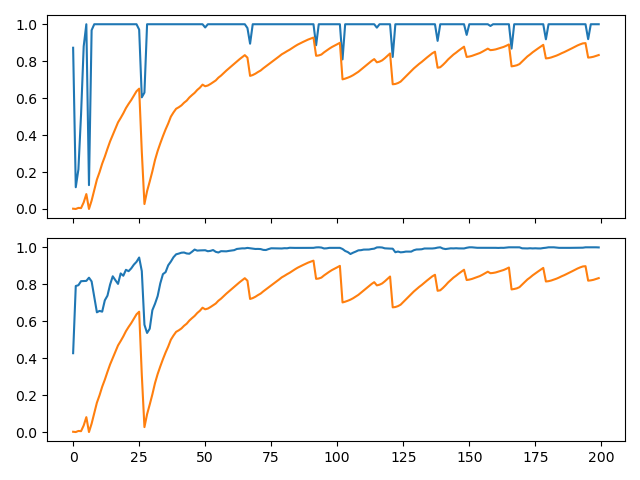

In [11]:
import pickle 
with open('sensitivity_200_epochs.pkl', 'rb') as f:
    sensitivity_plot_old = pickle.load(f)
    
with open('specificity_200_epochs.pkl', 'rb') as f:
    specificity_plot_old = pickle.load( f)
    
with open('thresh_200_epochs.pkl', 'rb') as f:
    thresh_plot_old = pickle.load( f)

fig, axs = plt.subplots(2,1,sharex=True)

axs[0].plot(sensitivity_plot_old,label='Sensitivity')
axs[0].plot(thresh_plot_old,label='Threshold')

axs[1].plot(specificity_plot_old,label='Specificity')
axs[1].plot(thresh_plot_old,label='Threshold')

axs[0]
fig.tight_layout()
plt.show()

In [12]:
import pickle
with open('sensitivity_100_epochs.pkl', 'wb') as f:
    pickle.dump(sensitivity_plot, f)
    
with open('specificity_100_epochs.pkl', 'wb') as f:
    pickle.dump(specificity_plot, f)
    
with open('thresh_100_epochs.pkl', 'wb') as f:
    pickle.dump(thresh_plot, f)

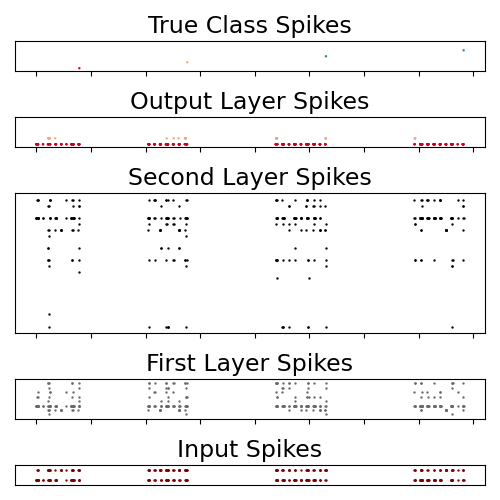

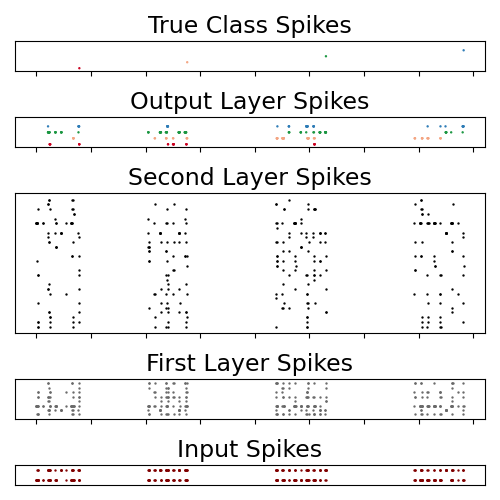

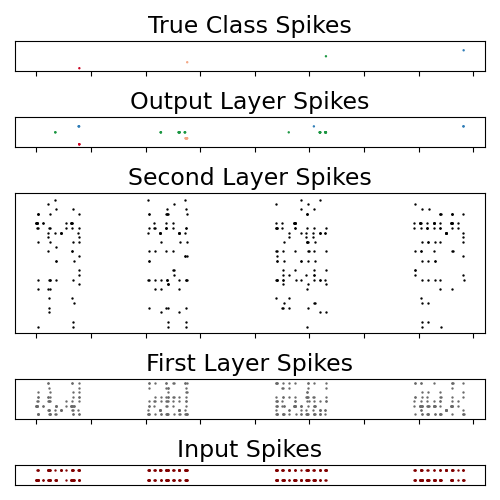

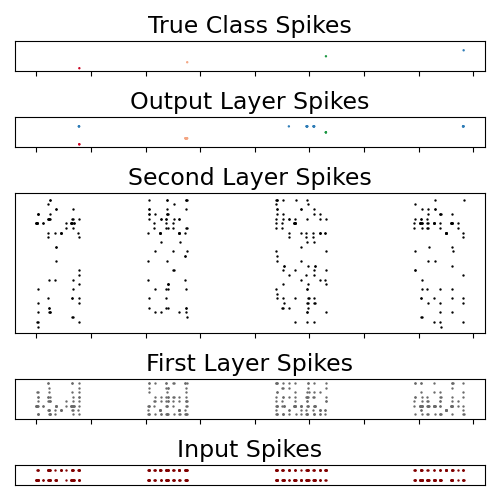

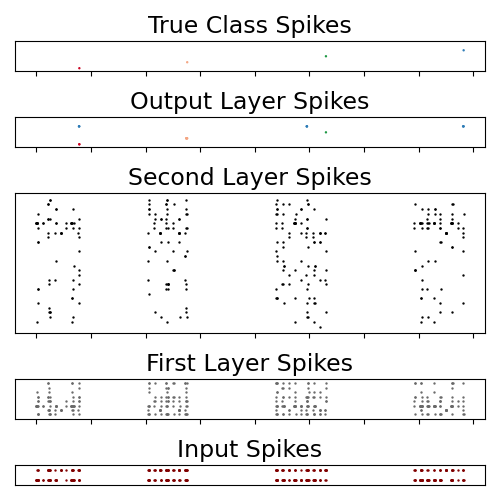

In [10]:
# data_plot, first_plot, second_plot, output_plot, true_plot = run_testing(model,testEnv)
fontsize = 17
spikesize = 0.5

for plot in range(0,100,20):
    data_plot = data_plots[plot]
    first_plot = first_plots[plot]
    second_plot = second_plots[plot]
    output_plot = output_plots[plot]
    true_plot = true_plots[plot]


    fig, axs = plt.subplots(5, 1, sharex=True ,gridspec_kw={'height_ratios': [output_layer_n_classes+2,output_layer_n_classes*output_layer_n_neurons_per_class+2,second_layer_n_neurons,first_layer_n_neurons,dim+2]},figsize=(5,5))

    

    if len(true_plot) > 0:
        colors = pltcolor(true_plot)
        true_plot = np.asarray(true_plot)
        axs[0].scatter(true_plot[:,1],true_plot[:,0],s=spikesize,c=colors)
        axs[0].tick_params(axis='y',left=False,labelleft=False)
        axs[0].title.set_text('True Class Spikes')
        axs[0].title.set_fontsize(fontsize)
        axs[0].set_ylim([-0.5, 4.5])
        

    if len(output_plot) > 0:
        colors = pltcolor(output_plot)
        output_plot = np.asarray(output_plot)
        axs[1].scatter(output_plot[:,1],output_plot[:,0],s=spikesize,c=colors)
        axs[1].tick_params(axis='y',left=False,labelleft=False)
        axs[1].title.set_text('Output Layer Spikes')
        axs[1].title.set_fontsize(fontsize)
        axs[1].set_ylim([-0.5, 4.5])
        
        

    if len(second_plot) > 0:
        second_plot = np.asarray(second_plot)
        axs[2].scatter(second_plot[:,1],second_plot[:,0],s=spikesize,c='black')
        axs[2].tick_params(axis='y',left=False,labelleft=False)
        axs[2].title.set_text('Second Layer Spikes')
        axs[2].title.set_fontsize(fontsize)
        

    if len(first_plot) > 0:
        first_plot = np.asarray(first_plot)
        axs[3].scatter(first_plot[:,1],first_plot[:,0],s=spikesize,c='dimgray')
        axs[3].tick_params(axis='y',left=False,labelleft=False)
        axs[3].set_ylim(-1,first_layer_n_neurons)
        axs[3].title.set_text('First Layer Spikes')
        axs[3].title.set_fontsize(fontsize)
        

    if len(data_plot) > 0:
        data_plot = np.asarray(data_plot)
        axs[4].scatter(data_plot[:,1],data_plot[:,0],s=spikesize,c='maroon')
        axs[4].tick_params(axis='both',left=False,labelleft=False,bottom=False,labelbottom=False)
        axs[4].set_ylim(-0.5,1.5)
        axs[4].title.set_text('Input Spikes')
        axs[4].title.set_fontsize(fontsize)
        
    
    fig.tight_layout()

    

In [10]:
plt.savefig("shall_I_compare_detection.svg", format="svg")